<a href="https://colab.research.google.com/github/BomiaoZh/bachelor/blob/main/bachelor1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 20.2 MB/s eta 0:00:00


,repo,license_count,versionInfo_count,skosConcept_count,owlClass_count,title_count,languages_count,license_score,versionInfo_score,skosConcept_score,owlClass_score,title_score,languages_score,Interoperability_score,Sustainability_score,Multilinguality_score,overall_score
0,LOV,266,2499,5183,53585,3929,111,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
1,BioPortal,100,50,100,100,0,0,1.0,1.0,1.0,1.0,0.0,0.0,0.666667,1.0,0.0,0.629630
2,OLS,100,50,100,100,100,0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,1.0,0.0,0.777778
3,BARTOC,100,0,100,100,100,0,1.0,0.0,1.0,1.0,1.0,0.0,1.000000,0.5,0.0,0.611111
4,CLARIAH,100,50,100,100,100,0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,1.0,0.0,0.777778



=== JSON output (evaluate_all) ===
[
  {
    "repo": "LOV",
    "license_count": 266,
    "versionInfo_count": 2499,
    "skosConcept_count": 5183,
    "owlClass_count": 53585,
    "title_count": 3929,
    "languages_count": 111,
    "license_score": 1.0,
    "versionInfo_score": 1.0,
    "skosConcept_score": 1.0,
    "owlClass_score": 1.0,
    "title_score": 1.0,
    "languages_score": 1.0,
    "Interoperability_score": 1.0,
    "Sustainability_score": 1.0,
    "Multilinguality_score": 1.0,
    "overall_score": 1.0
  },
  {
    "repo": "BioPortal",
    "license_count": 100,
    "versionInfo_count": 50,
    "skosConcept_count": 100,
    "owlClass_count": 100,
    "title_count": 0,
    "languages_count": 0,
    "license_score": 1.0,
    "versionInfo_score": 1.0,
    "skosConcept_score": 1.0,
    "owlClass_score": 1.0,
    "title_score": 0.0,
    "languages_score": 0.0,
    "Interoperability_score": 0.6666666666666666,
    "Sustainability_score": 1.0,
    "Multilinguality_score": 0.0,
 

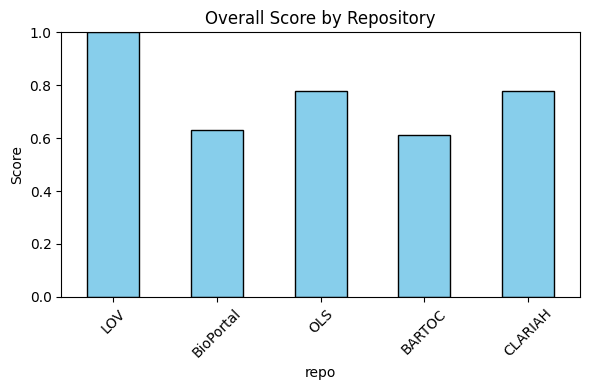

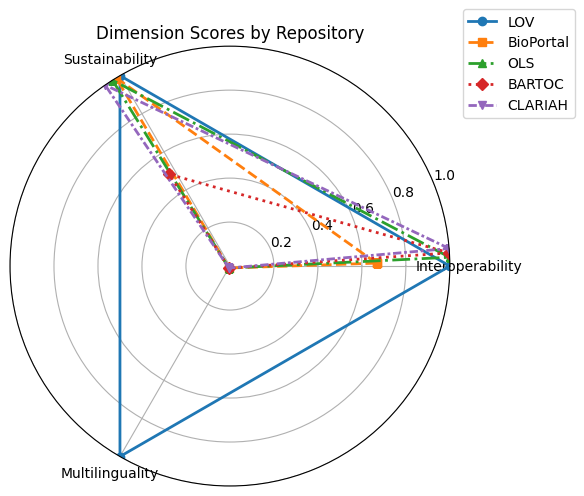

In [1]:
!pip install SPARQLWrapper pandas matplotlib


import logging
import json
from typing import List, Dict, Any

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from SPARQLWrapper import SPARQLWrapper, JSON

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# Configuration
ENDPOINTS = {
    "LOV": "https://lov.linkeddata.es/dataset/lov/sparql"
}

MANUAL_PRESENCE = [
    {"repo": "BioPortal", "license": True, "versionInfo": True, "skosConcept": True, "owlClass": True, "title": False},
    {"repo": "OLS", "license": True, "versionInfo": True, "skosConcept": True, "owlClass": True, "title": True},
    {"repo": "BARTOC", "license": True, "versionInfo": False, "skosConcept": True, "owlClass": True, "title": True},
    {"repo": "CLARIAH", "license": True, "versionInfo": True, "skosConcept": True, "owlClass": True, "title": True}
]

PREDICATES = {
    "license": "http://purl.org/dc/terms/license",
    "versionInfo": "http://www.w3.org/2002/07/owl#versionInfo",
    "skosConcept": "http://www.w3.org/2004/02/skos/core#Concept",
    "owlClass": "http://www.w3.org/2002/07/owl#Class",
    "title": "http://purl.org/dc/terms/title"
}

THRESHOLDS: Dict[str,int] = {
    "license_count": 100,
    "versionInfo_count": 50,
    "skosConcept_count": 100,
    "owlClass_count": 100,
    "title_count": 100,
    "languages_count": 3
}

DIMENSIONS = {
    "Interoperability": ["skosConcept_score", "owlClass_score", "title_score"],
    "Sustainability": ["license_score", "versionInfo_score"],
    "Multilinguality": ["languages_score"]
}

COUNT_TEMPLATE = """
SELECT (COUNT(DISTINCT ?s) AS ?cnt) WHERE {{
    {pattern}
}}
"""
LANGUAGE_TEMPLATE = """
SELECT DISTINCT (lang(?label) AS ?lang) WHERE {{
  {union_clause}
  FILTER(lang(?label) != "")
}}
"""
LABEL_UNION = """
{{ ?s <http://www.w3.org/2000/01/rdf-schema#label> ?label . }}
UNION
{{ ?s <http://www.w3.org/2004/02/skos/core#prefLabel> ?label . }}
"""

# SPARQL helper functions
def count_triples(endpoint: str, key: str) -> int:
    sparql = SPARQLWrapper(endpoint)
    sparql.setReturnFormat(JSON)
    pattern = (
        f"?s a <{PREDICATES[key]}> ."
        if key in ("skosConcept", "owlClass")
        else f"?s <{PREDICATES[key]}> ?o ."
    )
    sparql.setQuery(COUNT_TEMPLATE.format(pattern=pattern))
    try:
        res = sparql.query().convert()
        return int(res["results"]["bindings"][0]["cnt"]["value"])
    except Exception as e:
        logging.warning(f"{key}@{endpoint} -> 0 ({e.__class__.__name__})")
        return 0

def count_languages(endpoint: str) -> int:
    sparql = SPARQLWrapper(endpoint)
    sparql.setReturnFormat(JSON)
    sparql.setQuery(LANGUAGE_TEMPLATE.format(union_clause=LABEL_UNION))
    try:
        res = sparql.query().convert()
        langs = {b["lang"]["value"] for b in res["results"]["bindings"]}
        return len(langs)
    except Exception as e:
        logging.warning(f"languages@{endpoint} -> 0 ({e.__class__.__name__})")
        return 0

# Build evaluation matrix
def evaluate_endpoint(endpoint: str, name: str) -> Dict[str,Any]:
    entry = {"repo": name}
    for key in PREDICATES:
        entry[f"{key}_count"] = count_triples(endpoint, key)
    entry["languages_count"] = count_languages(endpoint)
    return entry

def build_manual_data() -> List[Dict[str,Any]]:
    rows: List[Dict[str,Any]] = []
    for m in MANUAL_PRESENCE:
        row = {"repo": m["repo"]}
        for key in PREDICATES:
            row[f"{key}_count"] = THRESHOLDS[f"{key}_count"] if m[key] else 0
        row["languages_count"] = 0
        rows.append(row)
    return rows

# Execute automatic and manual evaluation
evaluated = [evaluate_endpoint(url, name) for name, url in ENDPOINTS.items()]
evaluated.extend(build_manual_data())

# Create DataFrame
df = pd.DataFrame(evaluated)

# Normalize counts to scores
for cnt_col, thresh in THRESHOLDS.items():
    score_col = cnt_col.replace("_count", "_score")
    df[score_col] = (df[cnt_col] / thresh).clip(0,1)

# Compute dimension-level scores
for dim, cols in DIMENSIONS.items():
    df[f"{dim}_score"] = df[cols].mean(axis=1)

# Compute overall_score
score_columns = [c for c in df.columns if c.endswith("_score")]
df["overall_score"] = df[score_columns].mean(axis=1)

# Display DataFrame in notebook
from IPython.display import display
display(df)

# Print JSON equivalent to GET /evaluate_all
print("\n=== JSON output (evaluate_all) ===")
print(json.dumps(df.to_dict(orient="records"), ensure_ascii=False, indent=2))

# Visualization
# Bar chart of overall scores
plt.figure(figsize=(6,4))
df.set_index("repo")["overall_score"].plot.bar(color="skyblue", edgecolor="k")
plt.title("Overall Score by Repository")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Radar chart for dimension scores
labels = list(DIMENSIONS.keys())
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

colors = {
    "LOV": "#1f77b4",
    "BioPortal": "#ff7f0e",
    "OLS": "#2ca02c",
    "BARTOC": "#d62728",
    "CLARIAH": "#9467bd"
}
markers = {"LOV":"o","BioPortal":"s","OLS":"^","BARTOC":"D","CLARIAH":"v"}
linestyles = {"LOV":"-","BioPortal":"--","OLS":"-.","BARTOC":":","CLARIAH":(0,(3,1,1,1))}

plt.figure(figsize=(6,6))
for idx, row in df.iterrows():
    repo = row["repo"]
    values = [row[f"{dim}_score"] for dim in labels]
    if values[-1] == 0:
        values[-1] = 0.01  # jitter for visibility
    values += [values[0]]
    shift = idx * 0.02
    shifted_angles = [a + shift for a in angles]
    plt.polar(
        shifted_angles, values,
        color=colors[repo],
        marker=markers[repo],
        linestyle=linestyles[repo],
        linewidth=2,
        label=repo
    )

plt.thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Dimension Scores by Repository")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.ylim(0,1)
plt.tight_layout()
plt.show()